In [0]:
# from google.colab import drive
# drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# cd "gdrive/My Drive/final test challenge/CNN"

/content/gdrive/My Drive/final test challenge/CNN


# Demo_VGG16

 ## 1) Dependencies

In [0]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import os
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
import keras
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, MaxPooling2D,Conv2D
from keras.applications import VGG16
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import cv2
import numpy as np

Using TensorFlow backend.


# 2) Defining the architecture

In [0]:

#Architecture of the model

vgg16_model = VGG16(weights='imagenet')

'''Rebuild the vgg16 using an empty sequential model'''
model = Sequential()
layers = [layer for layer in vgg16_model.layers]
i = 0 
for layer in range(len (vgg16_model.layers) - 8):
    model.add(layers[i])
    i+=1

'''Freeze other pre-trained weights'''
for layer in model.layers:
    layer.trainable = True

'''Add the modified final layer'''
model.add(Conv2D(32, (3, 3), input_shape=(14, 14, 512)))
model.add(Activation('tanh'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('tanh'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('sigmoid'))
model.add(Dense(1))
model.add(Activation('relu'))


    
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
553467904/553467096 [==============================] - 6s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________

# 3) Loading the weights

In [0]:
model.load_weights("weights/VGG16_freezed_param.h5")

# 4) Predicting

In [0]:
# To only get 0 or 1 as final results 
def binarize(L):
  S= np.zeros(len(L))
  for i in range(len(L)):
    if L[i]>0.5:
      S[i] = 1
  return S


train = pd.read_csv("train.csv")
train.set_index('ImageId', inplace=True)


# test_folder_path: the folder where the images to predict are
# This function returns the predictions in a data frame format
def submit_test ( model, test_folder_path):

    images = [f for f in os.listdir(test_folder_path) if os.path.isfile(os.path.join(test_folder_path, f))]

    l_im = []
    l_name_test = []
    l_true_label = []
    for image in images:
            im_path = os.path.join(test_folder_path, image)
            im=mpimg.imread(im_path)
            l_true_label.append ( train.loc[image.split(".")[0],"Malignant"] )          
            l_im.append( cv2.resize(im, (224,224)))
            l_name_test.append(image)


    fig= plt.figure(figsize=(25, 20))
        
    i = 0 
    for im in l_im:
        i += 1 
        fig.add_subplot(len(l_im), 3, i)
        plt.imshow(im)
        plt.title(l_name_test[i-1])
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.6)
    plt.show()
    
    l_im_test = np.asarray(l_im)
    pred = model.predict(l_im_test)
    #test_df = pd.read_csv("data/test.csv")
    pred_finale = binarize(pred)
    pred_finale = [int(i) for i in pred_finale]
    


    d = {'ImageId': images, 'Malignant': pred_finale, "True_label": l_true_label}
    df_response = pd.DataFrame(data=d)
    return df_response

See table below to know the wrongly classified images


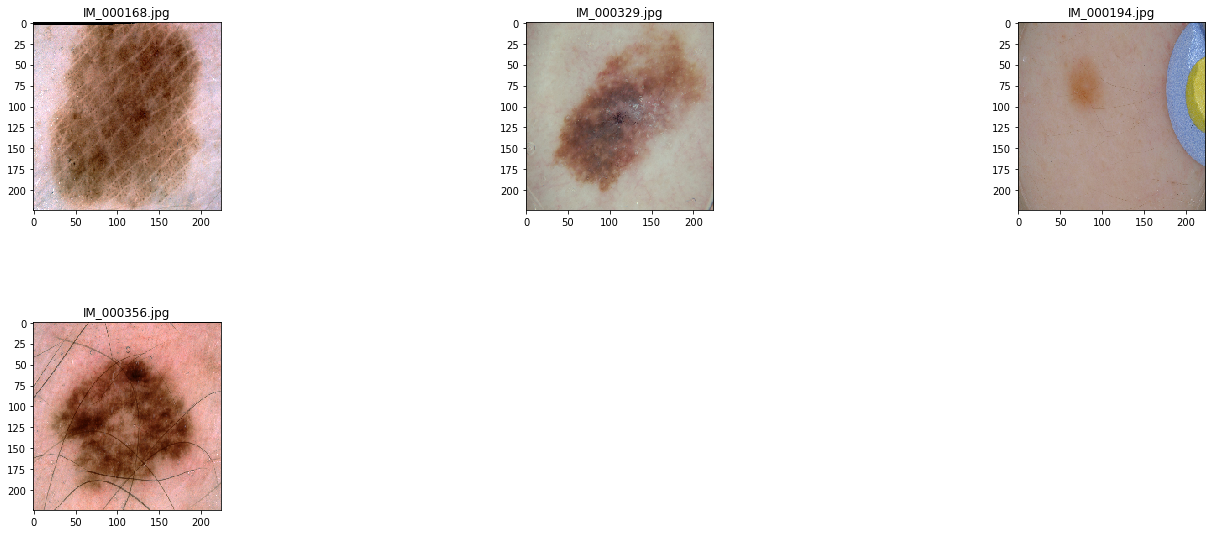

,ImageId,Malignant,True_label
0,IM_000168.jpg,0,1
1,IM_000329.jpg,0,0
2,IM_000194.jpg,0,0
3,IM_000356.jpg,0,0


In [0]:
# you can add your own images in the folder "example_data". 
print("See table below to know the wrongly classified images")
submit_test ( model,  "example_data")